# Import Librerie

In [73]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler

# Definizione funzioni

In [74]:
def RMSE_Loss(actual, predicted):
    """Root Mean Squared Error"""
    return torch.sqrt(torch.mean(torch.square(actual - predicted)))

In [75]:
def getRemoteDataset():
    return pd.read_csv('https://raw.githubusercontent.com/Uniba-dev-projects/forecasting-framework/master/synthetic_dataset.csv')    

In [76]:
def extractDataframeAndSeries(key, dataset):
    df = dataset[[key]]
    df = df.rename(columns={key: "t"}).reset_index()
    df.series = df.t.str.replace(",",".", regex=True).astype(float)
    return df, df.series.squeeze()

In [77]:
def calculateLoss(y, y_predicted):
    loss = []
    for i in range(len(y)):
        loss.append(abs(y[i]-y_predicted[i]))
    return loss

In [78]:
def showPerformanceGraph(label, portion, y_train, y_test, y_predicted_train, y_predicted_test, loss_train, loss_test, rmse_train, rmse_test):
    total = len(y_train) + len(y_test)
    plt.figure(figsize=(30,5))
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(0, total, 1), np.concatenate((y_train, y_test), axis=0))
    plt.plot(np.arange(0, total, 1), np.concatenate((y_predicted_train, y_predicted_test), axis=0))
    plt.axvline(x=total*portion, linestyle=":", color="red")
    plt.legend(["Series", "Predicted", "Train and test set splitter"])

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(0, total, 1), np.concatenate((loss_train, loss_test), axis=0))
    plt.axvline(x=total*portion, linestyle=":", color="red")
    plt.legend(["Loss", "Train and test set splitter"])

    plt.subplot(1, 3, 3)
    plt.plot(rmse_train)
    plt.plot(rmse_test)
    plt.legend(["RMSE Train", "RMSE Test"])
    
    plt.suptitle(label)

# Inizializzazione e Visualizazione Serie Temporali Sintentiche

In [79]:
dataset = getRemoteDataset()

In [80]:
_, series1 = extractDataframeAndSeries('y1(t) = t/1000 = y1(t-1)+0.001', dataset)
_, series2 = extractDataframeAndSeries('y2(t)=y2(t-1)*0.999', dataset)
_, series3 = extractDataframeAndSeries('y3(t)=y1(t)+y2(t)', dataset)
_, series4 = extractDataframeAndSeries('y4(t) = y4(t-1)-0.001', dataset)
_, series5 = extractDataframeAndSeries('y5(t)=y1(t)*t%2+y4(t)*(1-t%2)', dataset)

<AxesSubplot:xlabel='x', ylabel='y'>

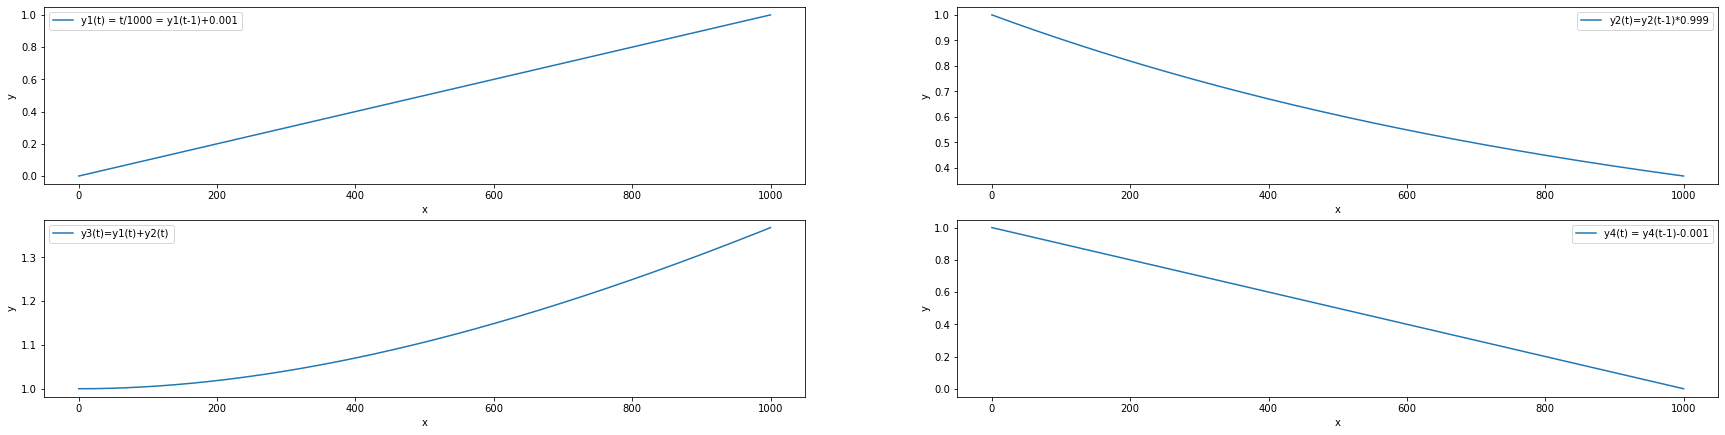

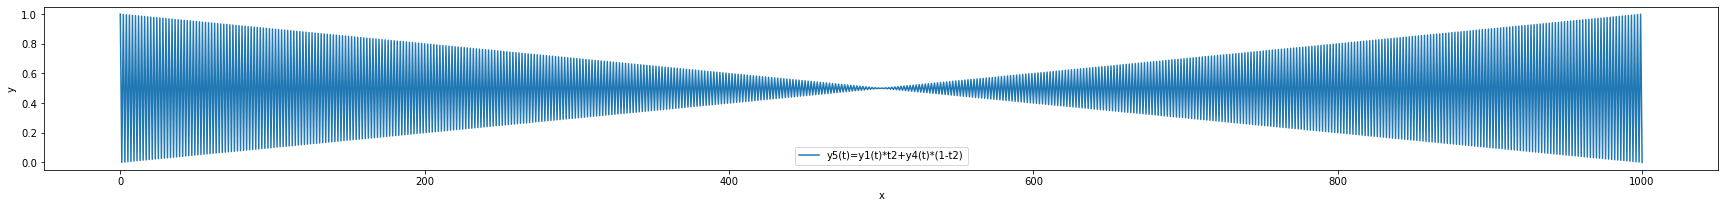

In [81]:
plt.figure(figsize=(30,15))

plt.subplot(4, 2, 1)
series1.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y1(t) = t/1000 = y1(t-1)+0.001")

plt.subplot(4, 2, 2)
series2.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y2(t)=y2(t-1)*0.999")

plt.subplot(4, 2, 3)
series3.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y3(t)=y1(t)+y2(t)")

plt.subplot(4, 2, 4)
series4.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y4(t) = y4(t-1)-0.001")

plt.figure(figsize=(30,3))
series5.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y5(t)=y1(t)*t2+y4(t)*(1-t2)")

# DatasetManager e Inizializzazione Long Short Term Memory
DatasetManager restituisce da una serie temporale un pandas.DataFrame definendo il nuemro di feature e il numero di variabili target.

In [82]:
class DatasetManager():
    def __getPandasFromNumpySeries(self, series, features_sequences=1, target_sequences=1, offset=0):

        dfTemp = pd.DataFrame({"ref": series})
        dfTemp.ref = dfTemp.ref.astype(float)
        for i in range(target_sequences):
            dfTemp['t+'+str(target_sequences-i)] = dfTemp.ref.shift(i)

        dfTemp['t'] = dfTemp.ref.shift(target_sequences)

        for j in range(features_sequences-1):
            dfTemp['t-'+str(j+1)] = dfTemp.ref.shift(target_sequences+j+1)

        dfTemp.drop(columns=["ref"], inplace=True)
        dropLine = features_sequences+target_sequences-1

        if(offset > 0):
            dfTemp['t'] = dfTemp['t'].shift(offset)
            for i in range(features_sequences-1):
                dfTemp['t-'+str(i+1)] = dfTemp['t-'+str(i+1)].shift(offset)
        
        dfTemp.drop(np.arange(0, dropLine+offset), inplace=True)
    
        return dfTemp[dfTemp.columns[::-1]].reset_index().drop(columns=["index"])
    
    def __getScaledDataFrame(self, df):
        tempColumns = df.columns
        scaler = MinMaxScaler()
        scalerDf = scaler.fit(df.to_numpy())
        df_scaled = scalerDf.transform(df)
        return pd.DataFrame(df_scaled, columns=tempColumns)

    def __init__(self, sequences, features_sequences=1, target_sequences=1, offset=0, portion=0.8):
        self.sequences = sequences
        self.features_sequences = features_sequences
        self.target_sequences = target_sequences
        self.offset = offset
        self.portion = portion
        tempDf = self.__getPandasFromNumpySeries(sequences, features_sequences, target_sequences, offset)
        self.df = self.__getScaledDataFrame(tempDf)

    def __len__(self):
        return len(self.sequences)

    def __train_set__(self):
        xCol = self.df[self.df.columns[0:self.features_sequences]].to_numpy()
        yCol = self.df[self.df.columns[self.features_sequences:]].to_numpy()
        return xCol[0: int(len(self.sequences)*self.portion)], yCol[0: int(len(self.sequences)*self.portion)]
    
    def __test_set__(self):
        xCol = self.df[self.df.columns[0:self.features_sequences]].to_numpy()
        yCol = self.df[self.df.columns[self.features_sequences:]].to_numpy()
        return  xCol[int(self.df['t'].size*self.portion):], yCol[int(self.df['t'].size*self.portion):]


In [83]:
class LSTM_Predictor(nn.Module):

    def __init__(self, input_dim, hidden_dim, seq_len, num_layers=2):
        super(LSTM_Predictor, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers
        hidden_defaults = torch.zeros(self.num_layers, self.seq_len, self.hidden_dim).cuda() if torch.cuda.is_available() else torch.zeros(self.num_layers, self.seq_len, self.hidden_dim)
        self.hidden = (hidden_defaults,hidden_defaults)
        self.lstm = nn.LSTM(
            input_size = input_dim,
            hidden_size = hidden_dim,
            num_layers = num_layers,
            dropout = .1
        )
        self.linear = nn.Linear(in_features=hidden_dim, out_features=1)

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        y_pred = self.linear(
            lstm_out.view(self.seq_len, len(sequences), self.hidden_dim)[-1]
        )
        return y_pred

In [84]:
def train_NN_model(model, train_data, train_labels, test_data, test_labels, num_epochs, inference = 10, verbose=True):
    
    if torch.cuda.is_available():
        model.train()

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    for t in range(num_epochs):
        y_train_pred = model(train_data)
        loss = RMSE_Loss(train_labels, y_train_pred)

        with torch.no_grad():
            y_test_pred = model(test_data[:-inference])
            test_loss = RMSE_Loss(test_labels[:-inference], y_test_pred)
        test_hist[t] = test_loss.item()

        if t % 10==0 and verbose is True:
            print(f'Epoch {t} train loss:{loss.item()} test loss: {test_loss.item()}')
        
        train_hist[t] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return model.eval(), train_hist, test_hist, y_test_pred, y_train_pred

In [85]:
def executeLSTM(label, series, feature_sequences=1, target_sequences=1, portion=0.8, offset=0, num_epochs=25, iterations=1):
    dataset = DatasetManager(
        series,
        features_sequences=feature_sequences,
        target_sequences=target_sequences,
        portion=portion,
        offset=offset
    )
    x_train, y_train = dataset.__train_set__()
    x_test, y_test = dataset.__test_set__()

    x_train_tensor = torch.tensor(data=x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(data=y_train, dtype=torch.float32)
    x_test_tensor = torch.tensor(data=x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(data=y_test, dtype=torch.float32)


    print(''.join(['> ' for i in range(50)]))
    print(f'\n{"EPOCH":<15}{"TRAINING RMSE":<18}{"TESTING RMSE":<18}\n')
    print(''.join(['> ' for i in range(50)]))
    model = LSTM_Predictor(input_dim=1, hidden_dim=128, seq_len=feature_sequences).to("cpu")
    rmse_TRAIN = []
    rmse_TEST = []
    x_trainDf2 = torch.tensor(data=x_train_tensor, dtype=torch.float32)
    y_trainDf2 = torch.tensor(data=y_train_tensor, dtype=torch.float32)
    x_testDf2 = torch.tensor(data=x_test_tensor, dtype=torch.float32)
    y_testDf2 = torch.tensor(data=y_test_tensor, dtype=torch.float32)

    for i in range(iterations):
        model, train_hist, test_hist, y_pred, y_pred_train, = train_NN_model(model, x_trainDf2, y_trainDf2, x_testDf2, y_testDf2, num_epochs=num_epochs, verbose=False)
        rmse_TEST.append(test_hist[num_epochs-1])
        rmse_TRAIN.append(train_hist[num_epochs-1])
        print(f'{(iterations - i):>3}) {str(num_epochs):<15}{train_hist[num_epochs-1]:<18.3f}{test_hist[num_epochs-1]:<18.3f}')
        
    
    showPerformanceGraph(
        label = label,
        portion=portion,
        y_train=y_train.squeeze(),
        y_test=y_test.squeeze()[:-10],
        y_predicted_train=y_pred_train.detach().numpy().flatten(),
        y_predicted_test=y_pred.detach().numpy().flatten(),
        loss_train=calculateLoss(y_train.squeeze(), y_pred_train.detach().numpy().flatten()),
        loss_test=calculateLoss(y_test.squeeze()[:-10], y_pred.detach().numpy().flatten()),
        rmse_train=rmse_TRAIN,
        rmse_test=rmse_TEST
    )

# Esecuzione Long Short Term Memory

In [86]:
features_length = 5 #Default 1 (Sostituire i valori per gli esperimenti)
offset = 3 #Default 0 (Sostituire i valori per gli esperimenti)
portion_train_test = 0.8 #Default 0.8 (Sostituire i valori per gli esperimenti)
num_epochs = 25
max_iter = 20

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 25             0.230             0.457             
 19) 25             2.933             2.461             
 18) 25             0.218             0.292             
 17) 25             0.186             0.095             
 16) 25             0.043             0.821             
 15) 25             0.088             1.758             
 14) 25             0.203             0.163             
 13) 25             0.125             0.285             
 12) 25             0.123             0.397             
 11) 25             1.263             1.736             
 10) 25             0.128             0.342             
  9) 25             0.031             0.375             
  8) 25             0.083             0.729             
  7

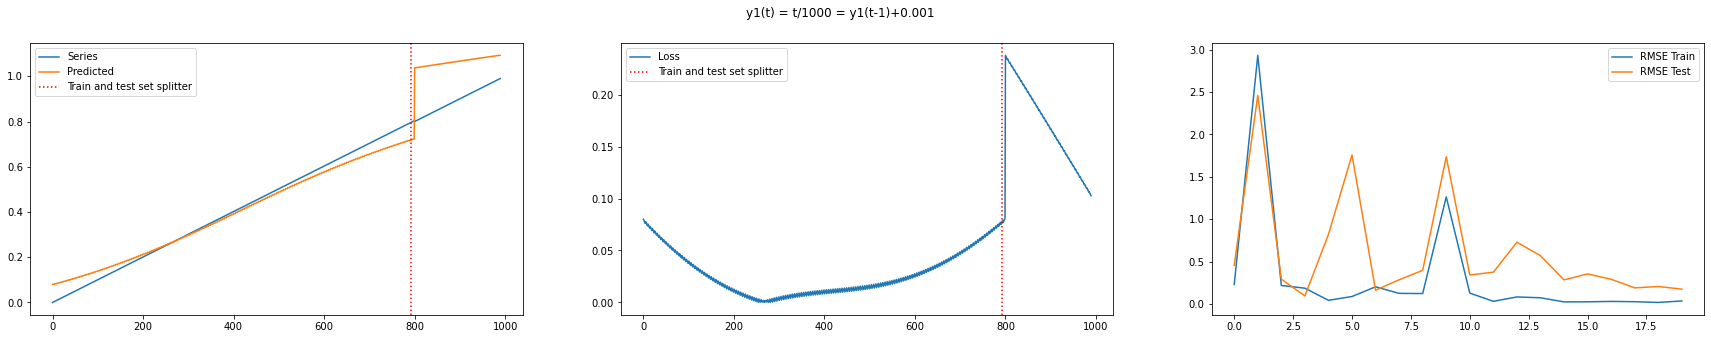

In [87]:
executeLSTM("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 25             0.252             0.472             
 19) 25             0.232             0.373             
 18) 25             0.257             0.177             
 17) 25             0.248             0.425             
 16) 25             0.206             0.226             
 15) 25             0.075             0.358             
 14) 25             0.137             0.028             
 13) 25             0.022             0.375             
 12) 25             0.055             0.410             
 11) 25             0.067             0.415             
 10) 25             0.041             0.365             
  9) 25             0.036             0.405             
  8) 25             0.063             0.441             
  7

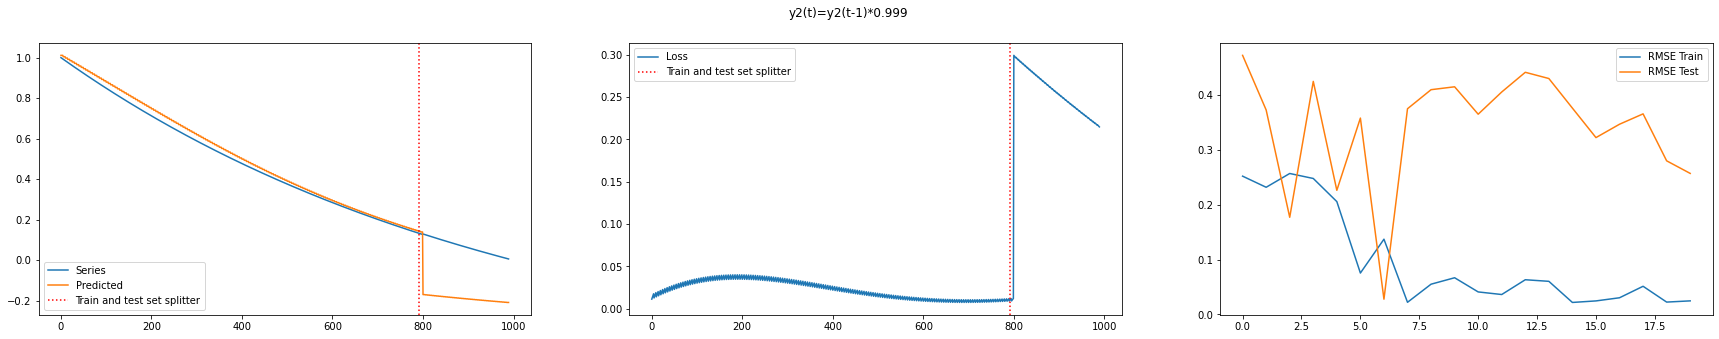

In [88]:
executeLSTM("y2(t)=y2(t-1)*0.999", series2, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 25             0.202             0.541             
 19) 25             0.199             0.347             
 18) 25             0.039             1.570             
 17) 25             0.156             0.172             
 16) 25             0.060             0.874             
 15) 25             0.054             0.637             
 14) 25             0.031             1.100             
 13) 25             0.044             0.435             
 12) 25             0.027             0.695             
 11) 25             0.021             0.715             
 10) 25             0.044             0.511             
  9) 25             0.019             0.520             
  8) 25             0.017             0.739             
  7

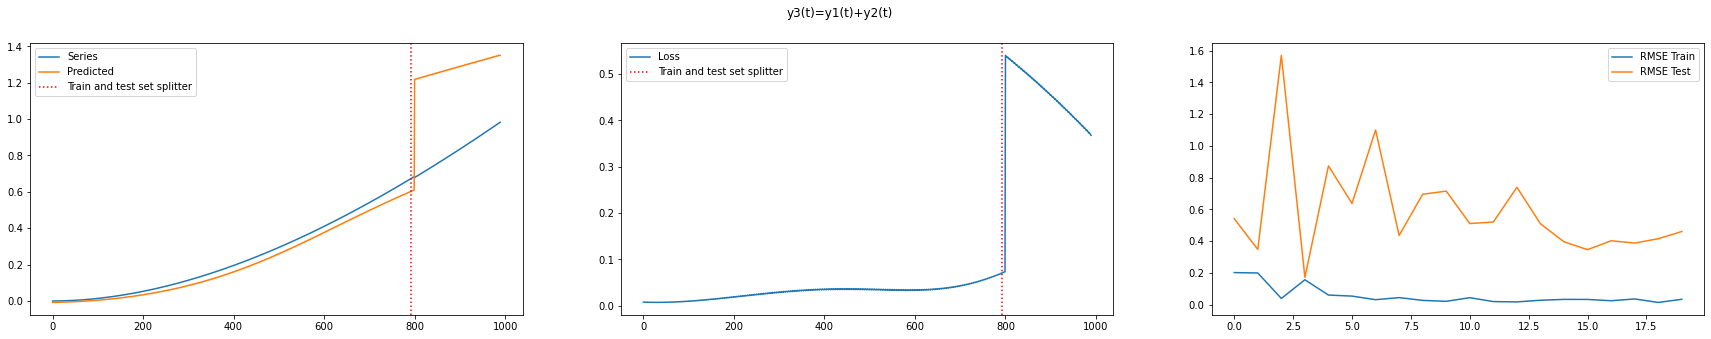

In [89]:
executeLSTM("y3(t)=y1(t)+y2(t)", series3, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 25             0.242             0.548             
 19) 25             0.218             0.441             
 18) 25             0.252             0.167             
 17) 25             0.196             0.318             
 16) 25             0.176             0.156             
 15) 25             0.105             0.137             
 14) 25             0.028             0.343             
 13) 25             0.072             0.229             
 12) 25             0.070             0.275             
 11) 25             0.051             0.398             
 10) 25             0.053             0.449             
  9) 25             0.021             0.340             
  8) 25             0.049             0.320             
  7

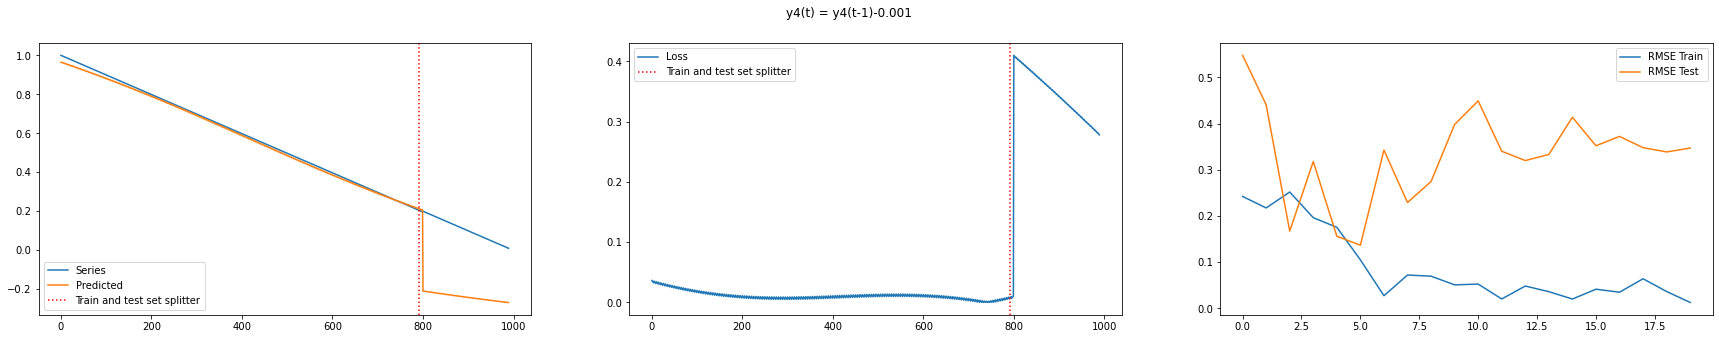

In [90]:
executeLSTM("y4(t) = y4(t-1)-0.001", series4, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 25             0.251             0.402             
 19) 25             0.250             0.404             
 18) 25             0.250             0.410             
 17) 25             0.248             0.433             
 16) 25             0.246             0.509             
 15) 25             0.246             0.497             
 14) 25             0.246             0.499             
 13) 25             0.246             0.500             
 12) 25             0.245             0.503             
 11) 25             0.229             0.463             
 10) 25             0.141             0.360             
  9) 25             0.249             0.417             
  8) 25             0.250             0.522             
  7

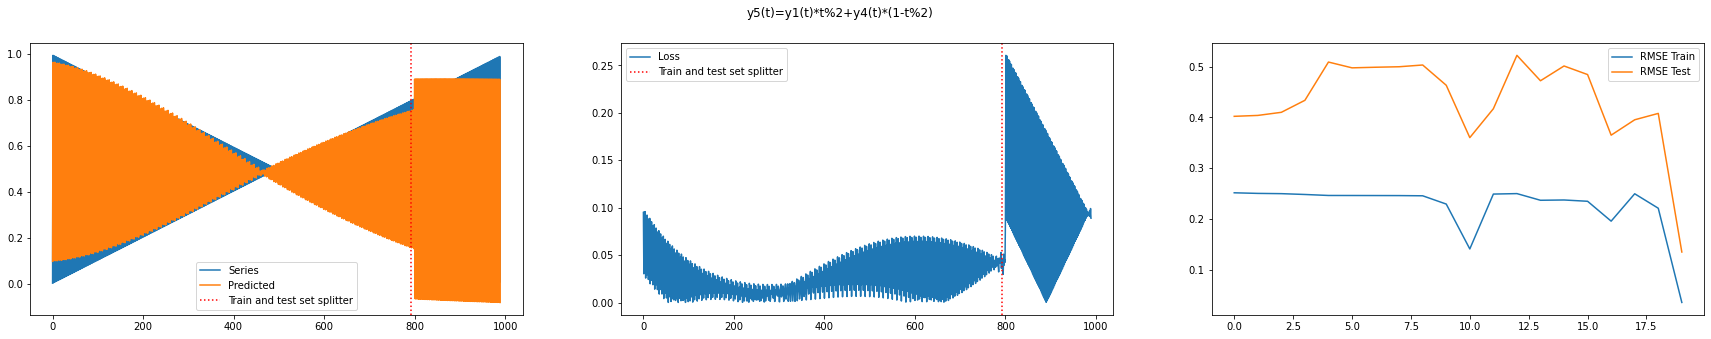

In [91]:
executeLSTM("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)